<a href="https://colab.research.google.com/github/alik604/CMPT-419/blob/master/ML_algo_compare_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing the libraries
import math
import datetime
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM

import matplotlib.pyplot as plt   # Import matplotlib

%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


!pip install fastparquet


     |████████████████████████████████| 153kB 2.8MB/s 
     |████████████████████████████████| 61kB 7.8MB/s 
  Created wheel for fastparquet: filename=fastparquet-0.3.3-cp36-cp36m-linux_x86_64.whl size=253672 sha256=04f7db02fe3d295838b3242c6c9ed9fe0d2295188c84abe0a8c2dbbc20440985
  Stored in directory: /root/.cache/pip/wheels/a0/27/9f/d8066bbbbb77e97d8ad3daf4de155ead73693bc4aa2f52098c
  Created wheel for thrift: filename=thrift-0.13.0-cp36-cp36m-linux_x86_64.whl size=345228 sha256=aaae5b5abd0d6812e05ebd268980adef3b7b4d7dccd4000868522fb9e1fbf1e1
  Stored in directory: /root/.cache/pip/wheels/02/a2/46/689ccfcf40155c23edc7cdbd9de488611c8fdf49ff34b1706e
Successfully built fastparquet thrift


In [87]:
dataset = pd.read_parquet('https://github.com/ddkpham/Stock_Prediction_NLP_ML/blob/master/wsb.hourly.joined.parquet.gz?raw=true', engine="fastparquet")
# dataset = data.set_index('created_utc')
dataset = dataset.iloc[:,29:]

dataset

,AAPL_StockPrice,AMZN_StockPrice,BA_StockPrice,SPY_StockPrice,TSLA_StockPrice
0,116.01,757.76,155.68,224.86,214.3
1,116.01,757.76,155.68,224.86,214.3
2,116.01,757.76,155.68,224.86,214.3
3,116.01,757.76,155.68,224.86,214.3
4,116.01,757.76,155.68,224.86,214.3
...,...,...,...,...,...
17017,248.56,1776.99,340.09,303.20,314.6
17018,248.56,1776.99,340.09,303.33,314.6
17019,248.56,1776.99,340.09,303.33,314.6
17020,248.56,1776.99,340.09,303.33,314.6


In [88]:
opening_dataset = dataset.SPY_StockPrice
dataset = dataset.drop(["SPY_StockPrice"],axis=1)
dataset

,AAPL_StockPrice,AMZN_StockPrice,BA_StockPrice,TSLA_StockPrice
0,116.01,757.76,155.68,214.3
1,116.01,757.76,155.68,214.3
2,116.01,757.76,155.68,214.3
3,116.01,757.76,155.68,214.3
4,116.01,757.76,155.68,214.3
...,...,...,...,...
17017,248.56,1776.99,340.09,314.6
17018,248.56,1776.99,340.09,314.6
17019,248.56,1776.99,340.09,314.6
17020,248.56,1776.99,340.09,314.6


In [89]:
scaler = MinMaxScaler(feature_range=(0,1))
openScaler = MinMaxScaler(feature_range=(0,1))

scaled_dataset = scaler.fit_transform(dataset)

scaled_open_prices = openScaler.fit_transform(opening_dataset.values.reshape(-1, 1))
scaled_open_prices

array([[0.01040628],
       [0.01040628],
       [0.01040628],
       ...,
       [0.98241053],
       [0.98241053],
       [0.98241053]])

In [0]:
training_data_len = math.ceil(len(dataset) * 0.8)
train_xvals = scaled_dataset[0:training_data_len, :]
train_yvals = scaled_open_prices[0:training_data_len, :]

In [0]:
test_xvals = scaled_dataset[training_data_len:, :]
test_yvals = scaled_open_prices[training_data_len:, :]

In [0]:
y_train = train_yvals
x_train = train_xvals

y_test = test_yvals
x_test = test_xvals

In [93]:
train_xvals.shape
test_xvals.shape
scaled_dataset.shape

(13618, 4)

(3404, 4)

(17022, 4)

In [61]:
x_train = []
y_train = []

maxlen = 20

for i in range(maxlen, len(train_xvals)): #  len(X_scaled_train)+1) changed added +1; X_scaled_train and x_train[-1], have the same last elem; they are synced 
  x_train.append(train_xvals[i-maxlen: i, :])
  y_train.append(train_yvals[i])

np.array(x_train).shape

(13598, 20, 4)

In [63]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM, CuDNNGRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

x_train, y_train = np.array(x_train), np.array(y_train)

model = Sequential()

model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(135, return_sequences=True))   # recurrent_dropout=0.1 will prevent cuDNN, using TF2
model.add(Dense(160))
model.add(LSTM(160, return_sequences=False))  
model.add(Dense(60))
model.add(Dense(1))

# Compile Model 
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss='mean_squared_error') # metrics=['mean_squared_error', 'mae']

batch_size = 16
callbacks=[]


# callbacks.append(EarlyStopping(monitor='loss', patience=12, verbose=1, mode='min', restore_best_weights=False)) # end if loss converges 
stop = EarlyStopping(monitor='loss', patience=10, verbose=1, mode='min', restore_best_weights=True) # end if val_loss converges 
callbacks.append(stop)  
callbacks.append(ModelCheckpoint('./my_model.hdf5', save_best_only=True, monitor='loss', mode='min'))
callbacks.append(ReduceLROnPlateau(monitor='loss', factor=0.5, patience=6, verbose=1, mode='min'))

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=45,  callbacks=callbacks,shuffle=True) 

Epoch 1/45
850/850 [==============================] - 10s 11ms/step - loss: 0.0090 - lr: 0.0010
Epoch 2/45
850/850 [==============================] - 9s 11ms/step - loss: 0.0029 - lr: 0.0010
Epoch 3/45
850/850 [==============================] - 9s 11ms/step - loss: 0.0022 - lr: 0.0010
Epoch 4/45
850/850 [==============================] - 10s 11ms/step - loss: 0.0018 - lr: 0.0010
Epoch 5/45
850/850 [==============================] - 9s 11ms/step - loss: 0.0016 - lr: 0.0010
Epoch 6/45
850/850 [==============================] - 9s 11ms/step - loss: 0.0014 - lr: 0.0010
Epoch 7/45
850/850 [==============================] - 10s 11ms/step - loss: 0.0013 - lr: 0.0010
Epoch 8/45
850/850 [==============================] - 10s 12ms/step - loss: 0.0012 - lr: 0.0010
Epoch 9/45
850/850 [==============================] - 10s 11ms/step - loss: 0.0011 - lr: 0.0010
Epoch 10/45
850/850 [==============================] - 9s 11ms/step - loss: 0.0011 - lr: 0.0010
Epoch 11/45
850/850 [=======================

In [64]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 20, 100)           42000     
_________________________________________________________________
lstm_16 (LSTM)               (None, 20, 135)           127440    
_________________________________________________________________
dense_24 (Dense)             (None, 20, 160)           21760     
_________________________________________________________________
lstm_17 (LSTM)               (None, 160)               205440    
_________________________________________________________________
dense_25 (Dense)             (None, 60)                9660      
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 61        
Total params: 406,361
Trainable params: 406,361
Non-trainable params: 0
________________________________________________

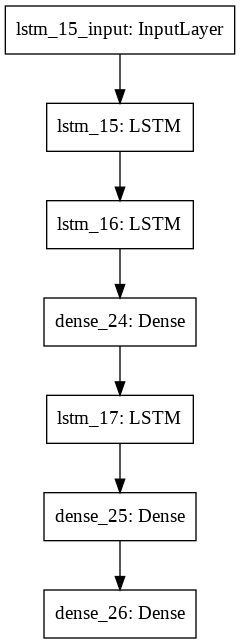

In [65]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [74]:
x_test = []
y_test = test_yvals[:-20]

for i in range(maxlen, len(test_xvals)): 
  x_test.append(test_xvals[i-maxlen:i, :]) 

x_test = np.array(x_test)


predictions = model.predict(x_test, batch_size=batch_size)
rmse_LSTM = np.sqrt(np.mean((openScaler.inverse_transform(predictions.reshape(-1, 1))- openScaler.inverse_transform(y_test.reshape(-1, 1)))**2))
rmse_LSTM # 12.474914716503145


12.474914716503145

In [75]:
from tensorflow.keras.layers import Dense, LSTM,GRU 
model = Sequential()

model.add(GRU(100, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(GRU(135, return_sequences=True))   # recurrent_dropout=0.1 will prevent cuDNN, using TF2
model.add(Dense(160))
model.add(GRU(160, return_sequences=False))  
model.add(Dense(60))
model.add(Dense(1))

# Compile Model 
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss='mean_squared_error') 

batch_size = 16
callbacks=[]

stop = EarlyStopping(monitor='loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
callbacks.append(stop)  
callbacks.append(ModelCheckpoint('./my_model.hdf5', save_best_only=True, monitor='loss', mode='min'))
callbacks.append(ReduceLROnPlateau(monitor='loss', factor=0.5, patience=6, verbose=1, mode='min'))

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=45,  callbacks=callbacks,shuffle=True) 

predictions = model.predict(x_test, batch_size=batch_size)
rmse_GRU = np.sqrt(np.mean((openScaler.inverse_transform(predictions.reshape(-1, 1))- openScaler.inverse_transform(y_test.reshape(-1, 1)))**2))
rmse_GRU # 15.126561829394966


Epoch 1/45
850/850 [==============================] - 9s 11ms/step - loss: 0.0102 - lr: 0.0010
Epoch 2/45
850/850 [==============================] - 9s 11ms/step - loss: 0.0040 - lr: 0.0010
Epoch 3/45
850/850 [==============================] - 9s 11ms/step - loss: 0.0025 - lr: 0.0010
Epoch 4/45
850/850 [==============================] - 9s 11ms/step - loss: 0.0019 - lr: 0.0010
Epoch 5/45
850/850 [==============================] - 9s 11ms/step - loss: 0.0016 - lr: 0.0010
Epoch 6/45
850/850 [==============================] - 9s 11ms/step - loss: 0.0014 - lr: 0.0010
Epoch 7/45
850/850 [==============================] - 9s 11ms/step - loss: 0.0013 - lr: 0.0010
Epoch 8/45
850/850 [==============================] - 9s 10ms/step - loss: 0.0012 - lr: 0.0010
Epoch 9/45
850/850 [==============================] - 9s 10ms/step - loss: 0.0011 - lr: 0.0010
Epoch 10/45
850/850 [==============================] - 9s 10ms/step - loss: 9.9556e-04 - lr: 0.0010
Epoch 11/45
850/850 [========================

15.126561829394966

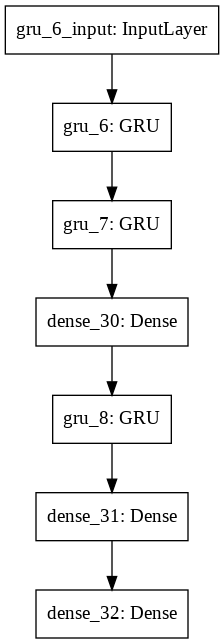

In [76]:
plot_model(model)

In [0]:
y_train = train_yvals
x_train = train_xvals

y_test = test_yvals
x_test = test_xvals

In [0]:
# from tensorflow.keras.layers import Dense, LSTM,GRU 
# model = Sequential()

# model.add(Dense(160)) 
# model.add(Dense(60))
# model.add(Dense(1))

# # Compile Model 
# model.compile(optimizer='adam', loss='mean_squared_error') 

# batch_size = 16
# callbacks=[]

# stop = EarlyStopping(monitor='loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
# callbacks.append(stop)  
# callbacks.append(ModelCheckpoint('./my_model.hdf5', save_best_only=True, monitor='loss', mode='min'))
# callbacks.append(ReduceLROnPlateau(monitor='loss', factor=0.5, patience=6, verbose=1, mode='min'))

# history = model.fit(x_train, y_train, batch_size=batch_size, epochs=150,  callbacks=callbacks,shuffle=True) 

In [54]:
# predictions = model.predict(x_test, batch_size=batch_size)
# rmse_MLP = np.sqrt(np.mean((openScaler.inverse_transform(yhat.reshape(-1, 1))- openScaler.inverse_transform(y_test.reshape(-1, 1)))**2))
# rmse_MLP #17.856727259041

17.856727259041

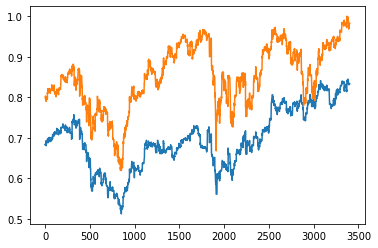

In [55]:
plt.plot(predictions)
plt.plot(y_test)

In [0]:
y_train = train_yvals
x_train = train_xvals

y_test = test_yvals
x_test = test_xvals

## SVM & RandomForestRegressor & bayesian regression

In [0]:
from sklearn.svm import SVR 
from sklearn.ensemble import RandomForestRegressor

In [97]:
reg = RandomForestRegressor(n_jobs=-1,n_estimators=999,random_state=42,criterion='mse')
reg.fit(x_train,y_train)

yhat = reg.predict(x_test)
MSE = mean_squared_error(openScaler.inverse_transform(yhat.reshape(-1, 1)), openScaler.inverse_transform(y_test.reshape(-1, 1)))
print('\nMSE: ',MSE)
RMSE_RFR = np.sqrt(MSE)
print('\nRMSE: ',RMSE_RFR)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=999, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)


MSE:  155.3289314362092

RMSE:  12.463102801317543


In [0]:
# plt.title("RandomForestRegressor")
# plt.plot(y,label ='obs');
# plt.plot(yhat,c='r',label = "pred");
# plt.legend();
# plt.show()

In [98]:
reg = SVR(kernel='rbf')
reg.fit(x_train,y_train)


yhat = reg.predict(x_test)

MSE = mean_squared_error(openScaler.inverse_transform(yhat.reshape(-1, 1)), openScaler.inverse_transform(y_test.reshape(-1, 1)))
print('\nMSE: ',MSE)
RMSE_SVM = np.sqrt(MSE)
print('\nRMSE: ',RMSE_SVM)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


MSE:  318.862708403778

RMSE:  17.856727259041


In [0]:
y_train = y_train.reshape(1,-1)[0]
y_test = y_test.reshape(1,-1)[0]

In [0]:
x_train = x_train.tolist()
x_test = x_test.tolist()
y_test = y_test.tolist()
y_train = y_train.tolist()


In [99]:
reg = GradientBoostingRegressor(n_estimators=200,max_depth=4)
reg.fit(x_train,y_train)


yhat = reg.predict(x_test)

MSE = mean_squared_error(openScaler.inverse_transform(yhat.reshape(-1, 1)), openScaler.inverse_transform(y_test.reshape(-1, 1)))
print('\nMSE: ',MSE)
RMSE_RGB = np.sqrt(MSE)
print('\nRMSE: ',RMSE_RGB)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


MSE:  174.72981956398246

RMSE:  13.218540750172934


In [0]:
# from sklearn.linear_model import ARDRegression # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html#sklearn.linear_model.BayesianRidge

# reg = ARDRegression(n_iter=300,tol = 0.001,compute_score=False)
# reg.fit(x_train,y_train)

# yhat = reg.predict(X_test)
# MSE = mean_squared_error(yhat,y_test)
# print('\nMSE - ARDRegression: ',MSE)
# RMSE_ARDRegression = np.sqrt(MSE)
# print('\nRMSE: ',RMSE_ARDRegression)

In [0]:
# from sklearn.linear_model import BayesianRidge
# reg = BayesianRidge(n_iter=300, tol = 0.001,compute_score=False)
# reg.fit(x,y)

# yhat = reg.predict(x_train)
# MSE = mean_squared_error(yhat,y_train)
# print('\nMSE - BayesianRidge : ',MSE) 
# RMSE_BayesianRidge = np.sqrt(MSE)
# print('\RMSE_BayesianRidge: ',RMSE_BayesianRidge)

In [0]:
from sklearn.linear_model import * # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html#sklearn.linear_model.BayesianRidge


In [124]:
scores

[13.218540750172934,
 12.463102801317543,
 17.856727259041,
 12.474914716503145,
 15.126561829394966,
 17.856727259041]

<BarContainer object of 6 artists>

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Legend does not support None instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  if sys.path[0] == '':


Text(0, 0.5, 'RMSE')

Text(0.5, 1.0, 'Comparison')

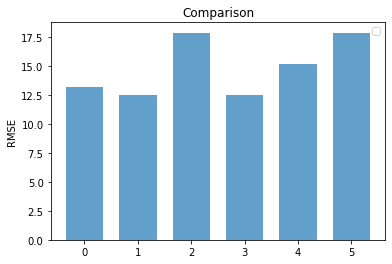

In [146]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

scores = [RMSE_RGB,       RMSE_RFR,       RMSE_SVM,rmse_LSTM, rmse_GRU,rmse_MLP ] #, RMSE_ARDRegression, RMSE_BayesianRidge
labels = ['Grad. boosting','Random Forest', 'SVM','LSTM', 'GRU','Mltilayer perceptron'] # 'Bayesian ARD regression', 'Bayesian ridge regression'
y_pos = np.arange(len(labels))
fig, ax = plt.subplots()
plt.bar(y_pos, scores,width=0.7, align='center', alpha=0.7)

ls = [ls.append(str(round(i,2))) for i in scores]
plt.legend(ls, labels)
ax.set_ylabel('RMSE')
ax.set_title('Comparison')
# ax.set_xticks(y_pos,labels)
# ax.set_xticklabels(labels, rotation = 45, ha="left")


# candle stick ploting 

In [0]:
# !pip install https://github.com/matplotlib/mpl_finance/archive/master.zip


In [0]:
#  from matplotlib.dates import DateFormatter, WeekdayLocator,    DayLocator, MONDAY
# from mpl_finance import candlestick_ohlc
 
# def pandas_candlestick_ohlc(dat, stick = "day", otherseries = None):
#     """
#     :param dat: pandas DataFrame object with datetime64 index, and float columns "Open", "High", "Low", and "Close", likely created via DataReader from "yahoo"
#     :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
#     :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines
 
#     This will show a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
#     """
#     mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
#     alldays = DayLocator()              # minor ticks on the days
#     dayFormatter = DateFormatter('%d')      # e.g., 12
 
#     # Create a new DataFrame which includes OHLC data for each period specified by stick input
#     transdat = dat.loc[:,["Open", "High", "Low", "Close"]]
#     if (type(stick) == str):
#         if stick == "day":
#             plotdat = transdat
#             stick = 1 # Used for plotting
#         elif stick in ["week", "month", "year"]:
#             if stick == "week":
#                 transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
#             elif stick == "month":
#                 transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
#             transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
#             grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
#             plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
#             for name, group in grouped:
#                 plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
#                                             "High": max(group.High),
#                                             "Low": min(group.Low),
#                                             "Close": group.iloc[-1,3]},
#                                            index = [group.index[0]]))
#             if stick == "week": stick = 5
#             elif stick == "month": stick = 30
#             elif stick == "year": stick = 365
 
#     elif (type(stick) == int and stick >= 1):
#         transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
#         grouped = transdat.groupby("stick")
#         plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
#         for name, group in grouped:
#             plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
#                                         "High": max(group.High),
#                                         "Low": min(group.Low),
#                                         "Close": group.iloc[-1,3]},
#                                        index = [group.index[0]]))
 
#     else:
#         raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')
 
 
#     # Set plot parameters, including the axis object ax used for plotting
#     fig, ax = plt.subplots()
#     fig.subplots_adjust(bottom=0.2)
#     if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
#         weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
#         ax.xaxis.set_major_locator(mondays)
#         ax.xaxis.set_minor_locator(alldays)
#     else:
#         weekFormatter = DateFormatter('%b %d, %Y')
#     ax.xaxis.set_major_formatter(weekFormatter)
 
#     ax.grid(True)
 
#     # Create the candelstick chart
#     candlestick_ohlc(ax, list(zip(list(date2num(plotdat.index.tolist())), plotdat["Open"].tolist(), plotdat["High"].tolist(),
#                       plotdat["Low"].tolist(), plotdat["Close"].tolist())),
#                       colorup = "black", colordown = "red", width = stick * .4)
 
#     # Plot other series (such as moving averages) as lines
#     if otherseries != None:
#         if type(otherseries) != list:
#             otherseries = [otherseries]
#         dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)
 
#     ax.xaxis_date()
#     ax.autoscale_view()
#     plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')
 
#     plt.show()
 
# #pandas_candlestick_ohlc(apple)
# FNGU = web.DataReader("FNGU", "yahoo", start, end)

# FNGU["14d"] = np.round(FNGU["Close"].rolling(window = 20, center = False).mean(), 2)
# pandas_candlestick_ohlc(FNGU.loc['2019-01-04':], otherseries = "14d") # FNGU.loc['201-01-04':'2016-08-07',:]